In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Bidirectional, Dropout, Activation, BatchNormalization,\
GlobalMaxPooling1D, Reshape, TextVectorization, Embedding, GRU, SimpleRNN, Concatenate, Dot, Lambda, RepeatVector, Softmax, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [3]:
# every image has 5 captions
!head -n 11 captions.txt

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


['A boy poses on a shadow-dappled lawn .', 'A boy running through green grass .', 'A child runs through the grass .', 'A young child in a white shirt is standing in a field of green grass', 'The boy wearing the blue shirt is running on the grass between the trees .']


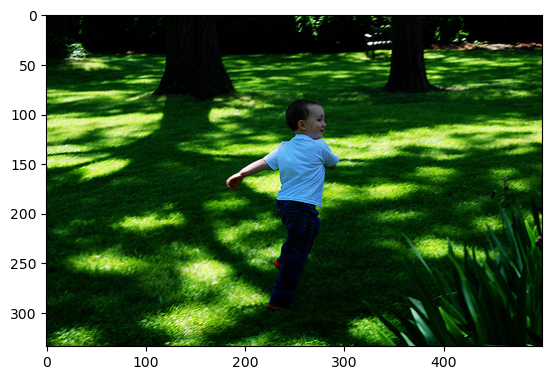

In [4]:
images = []
captions = []

with open("captions.txt", 'r') as f:
    next(f)
    for line in f:
        image_caption = line.strip().split(",", 1)
        if len(image_caption) == 2:
            i, c = image_caption
            if not images or images[-1] != i:
                images.append(i)
            captions.append(c)

rand = np.random.randint(0, len(images))
sample_image = images[rand]
print(captions[rand*5:rand*5+5])
plt.imshow(image.load_img(f'Images/{sample_image}'))
plt.show()

In [5]:
print(len(images), len(captions))

8091 40455


In [6]:
IMAGE_SIZE = [200, 200]

In [7]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False
)

In [8]:
ptm.trainable = False

In [9]:
print(ptm.summary())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [10]:
# output shape is 6*6*512
# should reshape for LSTM to 36*512
x = Reshape((-1, 512))(ptm.output)

In [11]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [12]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 512)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [13]:
image_features = []

for image_id in images:
  image = load_img(f"Images/{image_id}", target_size=IMAGE_SIZE)
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)

  features = model.predict(image)
  image_features.append(features.squeeze(axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━

In [14]:
print(image_features[rand].shape)

(36, 512)


In [15]:
start_token = "<start>"
end_token = "<end>"

for i in range(len(captions)):
    captions[i] = captions[i].lower()
    captions[i] = re.sub(r"[^a-z\s]", "", captions[i])
    captions[i] = f"{start_token} {captions[i]} {end_token}"

In [16]:
print(captions[rand*5])

<start> a boy poses on a shadowdappled lawn  <end>


In [17]:
MAX_VOCAB_SIZE = 20_000

In [19]:
vectorization_layer = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE
)
vectorization_layer.adapt(captions)
vectorized_captions = vectorization_layer(captions).numpy()

In [21]:
count = 0
for c in vectorized_captions:
    if len(c) != 37:
        count += 1
print(count)

0


In [22]:
print(vectorized_captions[rand*5])
print(len(vectorized_captions[rand*5]))

[   4    2   17  331    7    2 6037  374    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
37


In [23]:
def data_generator(image_features, vectorized_captions, batch_size):
    while True:
        X_image_batch = []
        X_caption_batch = []
        y_batch = []

        for i, features in enumerate(image_features):
            cap_of_img = vectorized_captions[i*5:i*5+5]

            for cap in cap_of_img:
                for t in range(1, len(cap)):
                    input_caption = cap[:t]
                    target = cap[t]

                    X_image_batch.append(features)
                    X_caption_batch.append(input_caption)
                    y_batch.append(target)

                    if len(X_image_batch) == batch_size:
                        X_caption_batch = tf.keras.preprocessing.sequence.pad_sequences(
                            X_caption_batch, maxlen=37, padding='post'
                        )
                        yield {
                            'image_input': np.array(X_image_batch),
                            'caption_input': np.array(X_caption_batch)
                        }, np.array(y_batch)
                        X_image_batch, X_caption_batch, y_batch = [], [], []

In [45]:
# Model definition with explicit layer names
img_i = Input(shape=(36, 512), name='image_input')
cap_i = Input(shape=(37,), name='caption_input', dtype='int32')

# encoder
img_x = GlobalMaxPooling1D()(img_i) # (N, 36, 512) -> (N, 512)
img_x = Dense(256, activation='relu')(img_x) # (N, 512) -> (N, 256)
img_x = BatchNormalization()(img_x) # (N, 256) -> (N, 256)
img_x = Dropout(0.2)(img_x) # (N, 256) -> (N, 256)

# embedding (masking tells model to ignore the padding)
cap_x = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(cap_i) # (N, 37) -> (N, 37, 256)
cap_x = Dropout(0.2)(cap_x) # (N, 37, 256) -> (N, 37, 256)
cap_x = Bidirectional(LSTM(256, return_sequences=True))(cap_x) # (N, 37, 256) -> (N, 37, 512)
cap_x = BatchNormalization()(cap_x) # (N, 37, 512) -> (N, 37, 512)
cap_x = Dropout(0.2)(cap_x) # (N, 37, 512) -> (N, 37, 512)

# attention
attention_x = Dense(128, activation='tanh')(cap_x) # (N, 37, 512) -> (N, 37, 128)
attention_x = BatchNormalization()(attention_x) # (N, 37, 128) -> (N, 37, 128)
attention_scores = Dense(1, activation='tanh')(attention_x) # (N, 37, 128) -> (N, 37, 1)
attention_scores = Reshape((37,))(attention_scores) # (N, 37, 1) -> (N, 37)
attention_weights = Dense(1, activation='softmax')(attention_scores) # (N, 37) -> (N, 1)
weighted_sum = Multiply()([cap_x, attention_weights]) # (N, 37, 512) * (N, 1) -> (N, 37, 512)
cap_x = GlobalMaxPooling1D()(weighted_sum) # (N, 37, 512) -> (N, 512)

# combine
x = Concatenate()([img_x, cap_x]) # (N, 256) and (N, 512) -> (N, 768)
x = Dense(512, activation='relu')(x) # (N, 768) -> (N, 512)
x = BatchNormalization()(x) # (N, 512) -> (N, 512)
x = Dropout(0.2)(x) # (N, 512) -> (N, 512)
x = Dense(MAX_VOCAB_SIZE, activation='softmax')(x) # (N, 512) -> (N, MAX_VOCAB_SIZE)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_10' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [34]:
model = Model(inputs=[img_i, cap_i], outputs=x)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [35]:
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 37, 256)   │  5,120,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 37, 256)   │          0 │ embedding_3[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 37)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 37, 512)   │  1,050,624 │ dropout_11[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 512)   │      2,048 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 37, 512)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 37, 128)   │     65,664 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 128)   │        512 │ dense_12[0][0],   │
│ (BatchNormalizatio… │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 36, 512)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 37, 1)     │        129 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ image_input[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 37)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 37, 512)   │          0 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         38 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 37, 512)   │          0 │ reshape_2[0][0],  │
│ (Multiply)          │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ batch_normalizat

 Total params: 17,027,143 (64.95 MB)

 Trainable params: 17,024,327 (64.94 MB)

 Non-trainable params: 2,816 (11.00 KB)

None


In [36]:
split_index = len(image_features) * 4 // 5

train_features = image_features[:split_index]
val_features = image_features[split_index:]

train_captions = vectorized_captions[:split_index * 5]
val_captions = vectorized_captions[split_index * 5:]

In [37]:
batch_size = 128

steps_per_epoch = len(train_features) * 5 // batch_size
validation_steps = len(val_features) * 5 // batch_size

# Create TensorFlow datasets with matching input names
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_features, train_captions, batch_size),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(batch_size, 36, 512), dtype=tf.float32),
            'caption_input': tf.TensorSpec(shape=(batch_size, 37), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_features, val_captions, batch_size),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(batch_size, 36, 512), dtype=tf.float32),
            'caption_input': tf.TensorSpec(shape=(batch_size, 37), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )
)

r = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


252/252 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - loss: 3.8894 - val_loss: 15.8948
Epoch 2/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - loss: 1.7330 - val_loss: 8.1143
Epoch 3/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - loss: 1.6233 - val_loss: 2.2410
Epoch 4/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - loss: 1.4886 - val_loss: 3.7201
Epoch 5/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - loss: 1.4784 - val_loss: 1.9827
Epoch 6/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - loss: 1.4116 - val_loss: 2.9708
Epoch 7/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 222ms/step - loss: 1.3689 - val_loss: 1.8142
Epoch 8/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - loss: 1.3412 - val_loss: 1.5926
Epoch 9/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 224ms/step - loss: 1.1570 - val_loss: 1.4791
Epoch 10/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - loss: 1.2786 - val_loss: 1.5130
Epoch 11/20
252/252 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step - loss: 1.2119 - val_loss: 1.4462
Epoch 12/20
252/252 ━━━━━━━━━

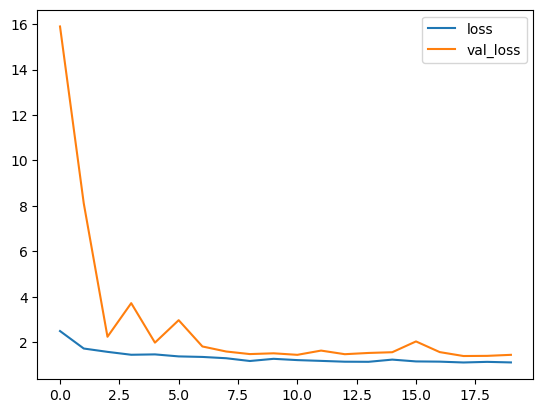

In [38]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [39]:
model.save("captioning_model.h5")

In [46]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
def generate_caption(model, image_features, vectorization_layer, max_length=37):
    # Initialize with start token
    caption = ['<start>']
    
    # Convert to sequence
    input_caption = vectorization_layer(caption).numpy()
    
    # Generate caption word by word
    for i in range(max_length):
        # Prepare inputs
        current_caption = tf.keras.preprocessing.sequence.pad_sequences(
            [input_caption], maxlen=37, padding='post'
        )
        
        # Make prediction
        predictions = model.predict(
            {
                'image_input': np.expand_dims(image_features, axis=0),
                'caption_input': current_caption
            }, 
            verbose=0
        )
        
        # Get predicted word index
        predicted_id = np.argmax(predictions[0])
        
        # Convert to word
        predicted_word = vectorization_layer.get_vocabulary()[predicted_id]
        
        # Break if end token
        if predicted_word == '<end>':
            break
            
        # Add to caption
        caption.append(predicted_word)
        input_caption = vectorization_layer(caption).numpy()
    
    return ' '.join(caption[1:])  # Remove start token

In [48]:
def evaluate_bleu(model, val_features, val_captions, vectorization_layer):
    references = []
    hypotheses = []
    
    # Generate predictions for validation set
    for i, image_feature in enumerate(val_features):
        # Get reference captions for this image (5 captions per image)
        image_captions = val_captions[i*5:(i+1)*5]
        reference = []
        
        # Process reference captions
        for cap in image_captions:
            # Convert indices back to words and tokenize
            cap_words = [vectorization_layer.get_vocabulary()[idx] for idx in cap if idx != 0]
            # Remove start and end tokens
            cap_words = [word for word in cap_words if word not in ['<start>', '<end>', '']]
            reference.append(cap_words)
        
        references.append(reference)
        
        # Generate prediction
        predicted_caption = generate_caption(model, image_feature, vectorization_layer)
        # Tokenize prediction
        hypothesis = predicted_caption.split()
        # Remove start and end tokens if present
        hypothesis = [word for word in hypothesis if word not in ['<start>', '<end>', '']]
        
        hypotheses.append(hypothesis)
        
        # Print progress
        if (i+1) % 100 == 0:
            print(f"Processed {i+1}/{len(val_features)} images")
    
    # Calculate BLEU scores
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4
    }

In [49]:
bleu_scores = evaluate_bleu(model, val_features, val_captions, vectorization_layer)

print("BLEU Scores:")
for metric, score in bleu_scores.items():
    print(f"{metric}: {score:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_1' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'reshape_2' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Processed 100/1619 images
Processed 200/1619 images
Processed 300/1619 images
Processed 400/1619 images
Processed 500/1619 images
Processed 600/1619 images
Processed 700/1619 images
Processed 800/1619 images
Processed 900/1619 images
Processed 1000/1619 images
Processed 1100/1619 images
Processed 1200/1619 images
Processed 1300/1619 images
Processed 1400/1619 images
Processed 1500/1619 images
Processed 1600/1619 images
BLEU Scores:
bleu1: 0.4908
bleu2: 0.2550
bleu3: 0.1232
bleu4: 0.0634
